In [2]:
!pip install numpy Pillow

## Dataset Generation & Rationale
To train the model, we require a synthetic dataset.
* **Size:** We generate 10,000 samples. Given a $50 \times 50$ grid, there are 2500 possible unique coordinate locations. 10,000 samples ensure the model sees every coordinate multiple times, providing a robust distribution for an 80/20 train/validation split without overfitting.
* **Distribution:** Coordinates are generated using a uniform random distribution (`np.random.randint`) to ensure no spatial bias exists in the training data.
* **Format:** The images are saved as individual `.png` files, and their exact $(x, y)$ ground truths are mapped in a `labels.csv` file. This mimics real-world data loading pipelines better than passing raw arrays in memory.

In [3]:
import os
import csv
import zipfile
import numpy as np
from PIL import Image

def generate_png_dataset(
    num_samples: int = 10000,
    img_size: int = 50,
    output_dir: str = 'dataset'
):
    """
    Generates single-pixel PNG images and a labels.csv file.
    """
    images_dir = os.path.join(output_dir, 'images')
    os.makedirs(images_dir, exist_ok=True)

    csv_path = os.path.join(output_dir, 'labels.csv')

    print(f"Generating {num_samples} images in '{images_dir}'...")

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write CSV header
        writer.writerow(['filename', 'x', 'y'])

        for i in range(num_samples):
            # Generate random x and y coordinates
            x = np.random.randint(0, img_size)
            y = np.random.randint(0, img_size)

            # Create a 50x50 numpy array of zeros (uint8 for image saving)
            img_array = np.zeros((img_size, img_size), dtype=np.uint8)
            img_array[y, x] = 255

            # Define filename and save as PNG
            filename = f"img_{i:05d}.png"
            filepath = os.path.join(images_dir, filename)

            # Convert array to PIL Image and save
            img = Image.fromarray(img_array, mode='L')
            img.save(filepath)

            # Record the filename and coordinates in the CSV
            writer.writerow([filename, x, y])

    print(f"Labels saved to '{csv_path}'.")

def zip_and_download_dataset(folder_path: str = 'dataset', zip_name: str = 'dataset.zip'):
    """
    Compresses the dataset folder into a zip file and triggers download.
    """
    print(f"Compressing '{folder_path}' into '{zip_name}'...")

    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # Ensure the internal zip structure is clean
                arcname = os.path.relpath(file_path, start=os.path.dirname(folder_path))
                zipf.write(file_path, arcname)

    file_size_mb = os.path.getsize(zip_name) / (1024 * 1024)
    print(f"Dataset compressed successfully! File size: {file_size_mb:.2f} MB")

    # Attempt to trigger a browser download if running in Google Colab
    try:
        from google.colab import files
        print("Google Colab environment detected. Initiating download...")
        files.download(zip_name)
    except ImportError:
        print(f"File saved locally at: {os.path.abspath(zip_name)}")

# --- Execution ---
if __name__ == "__main__":
    # 1. Generate the dataset folder and PNGs
    generate_png_dataset(num_samples=10000, img_size=50)

    # 2. Zip the folder and trigger download
    zip_and_download_dataset()

Generating 10000 images in 'dataset/images'...


/tmp/ipython-input-2947278114.py:41: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img_array, mode='L')


Labels saved to 'dataset/labels.csv'.
Compressing 'dataset' into 'dataset.zip'...
Dataset compressed successfully! File size: 2.08 MB
Google Colab environment detected. Initiating download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ML Assignment - Supervised Regression: Single Pixel Localization
**Objective:** Using Deep Learning techniques, predict the $(x, y)$ coordinates of a single bright pixel (value 255) in a 50x50 grayscale image where all other pixels are 0.

## 1. Problem Statement & Approach Philosophy
While this problem could be solved analytically with a simple `argmax` search, the requirement is to use Deep Learning regression. Standard approaches might default to deep Convolutional Neural Networks (CNNs). However, applying a deep CNN to a sparse 50x50 matrix is computationally wasteful.

Instead, this solution prioritizes **Edge AI and TinyML principles**: ultra-low latency, minimal memory footprint, and a reduction in Multiply-Accumulate (MAC) operations.
* We deploy a minimalist **2-Neuron Regressor**.
* The architecture maps the flattened 2500-pixel input directly to the 2 output coordinates without hidden layers or activation functions, relying purely on spatial weight optimization.

## 2. Model Architecture: The 2-Neuron Regressor
The architecture consists of a single linear layer (`nn.Linear`) mapping the flattened 2500-element input array directly to 2 output nodes (representing $x$ and $y$).

**Key Architectural Decisions:**
1. **No Hidden Layers:** The problem is perfectly linear; adding depth only increases latency and risk of overfitting.
2. **No Bias Term (`bias=False`):** Because the background is strictly 0, the model only needs to learn the positional weight of the single active pixel.
3. **Hardware Efficiency:** This model contains exactly 5,000 parameters. It requires barely a few kilobytes of memory, making it trivial to quantize and deploy on resource-constrained microcontrollers or FPGAs.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class TwoNeuronRegressor(nn.Module):
    def __init__(self, img_size: int = 50):
        super(TwoNeuronRegressor, self).__init__()
        self.img_size = img_size
        self.flatten_size = img_size * img_size

        # Literally just 2 neurons connected to all 2500 pixels. No bias.
        self.fc = nn.Linear(self.flatten_size, 2, bias=False)

    def forward(self, x):
        # Flatten the image from (Batch, 1, 50, 50) to (Batch, 2500)
        x = x.view(-1, self.flatten_size)

        # Pass through the 2 neurons
        x = self.fc(x)
        return x

    def early_exit_inference(self, single_image: torch.Tensor, threshold: float = 0.5):
        """
        Custom inference method simulating the microcontroller early-exit strategy.
        Expects a single image tensor of shape (1, 50, 50) or (50, 50).
        """
        # Ensure it's 1D for the loop
        flat_img = single_image.view(-1)

        for i, pixel_val in enumerate(flat_img):
            if pixel_val > threshold:
                # We found the bright pixel! Early exit!
                # Instead of standard matrix multiplication, we just grab the specific
                # weights connected to this pixel for Neuron 0 (X) and Neuron 1 (Y)
                # and multiply by the pixel value.

                # self.fc.weight shape is (2, 2500)
                predicted_x = self.fc.weight[0, i] * pixel_val
                predicted_y = self.fc.weight[1, i] * pixel_val

                return torch.tensor([predicted_x.item(), predicted_y.item()])

        # Fallback if image is completely black
        return torch.tensor([-1.0, -1.0])

## 3. Training Pipeline & Loss Optimization
Since this is a supervised regression task mapping to continuous spatial coordinates, we utilize **Mean Squared Error (MSE)** as our loss function.

**Training Optimizations:**
* **Target Normalization:** We divide the ground truth coordinates by the maximum grid size (49.0). This scales our targets to a $[0.0, 1.0]$ range, matching the scaled input tensors. This prevents the optimizer from struggling with step-size limits.
* **Learning Rate Scheduling:** We use the Adam optimizer coupled with a `MultiStepLR` scheduler. We start with an aggressive learning rate (`1.0`) to rapidly descend the loss gradient, and decay it at specific milestones (Epochs 10, 20, 45) to fine-tune the final sub-pixel coordinate weights.

In [11]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import pandas as pd

# 1. Define the Custom Dataset Class
class SinglePixelDataset(Dataset):
    def __init__(self, csv_file: str, img_dir: str, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # Read the filename from the first column
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert("L")  # Convert to grayscale

        # Ground truth coordinates [x, y] from the second and third columns
        y_label = torch.tensor([
            float(self.annotations.iloc[index, 1]),
            float(self.annotations.iloc[index, 2])
        ])

        if self.transform:
            image = self.transform(image)

        return image, y_label

# 2. Initialize Dataset and Transforms
transform = transforms.Compose([
    transforms.ToTensor() # Converts PIL Image to PyTorch Tensor [0.0, 1.0]
])

dataset = SinglePixelDataset(
    csv_file='dataset/labels.csv',
    img_dir='dataset/images',
    transform=transform
)

# 3. Partition the Data (80% Train, 20% Validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# random_split ensures the data is shuffled before splitting
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# 4. Create the DataLoaders
# batch_size=64 is a good default. shuffle=True is crucial for training!
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)


Total dataset size: 10000
Training set size: 8000
Validation set size: 2000


## 4. Training Pipeline & Loss Optimization
Since this is a supervised regression task mapping to continuous spatial coordinates, we utilize **Mean Squared Error (MSE)** as our loss function.

**Training Optimizations:**
* **Target Normalization:** We divide the ground truth coordinates by the maximum grid size (49.0). This scales our targets to a $[0.0, 1.0]$ range, matching the scaled input tensors. This prevents the optimizer from struggling with step-size limits.
* **Learning Rate Scheduling:** We use the Adam optimizer coupled with a `MultiStepLR` scheduler. We start with an aggressive learning rate (`1.0`) to rapidly descend the loss gradient, and decay it at specific milestones (Epochs 10, 20, 45) to fine-tune the final sub-pixel coordinate weights.

In [26]:
import torch.optim.lr_scheduler as lr_scheduler

def train_two_neuron_model(train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    model = TwoNeuronRegressor(img_size=50).to(device)
    criterion = nn.MSELoss()

    # Start with the high learning rate
    optimizer = optim.Adam(model.parameters(), lr=1.0)

    # Add a scheduler: Decays the learning rate by a factor of 0.1 every 7 epochs
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 45], gamma=0.1)
    num_epochs = 50

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, targets)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Step the scheduler AT THE END of every epoch
        scheduler.step()

        # Get current learning rate for printing
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch+1}/{num_epochs}] | LR: {current_lr:.4f} | Train Loss: {train_loss:.4f}")

    return model

# Run the training
model = train_two_neuron_model(train_loader, val_loader)

Training on: cpu
Epoch [1/50] | LR: 1.0000 | Train Loss: 561.5313
Epoch [2/50] | LR: 1.0000 | Train Loss: 156.1397
Epoch [3/50] | LR: 1.0000 | Train Loss: 40.6052
Epoch [4/50] | LR: 1.0000 | Train Loss: 11.8401
Epoch [5/50] | LR: 1.0000 | Train Loss: 4.4693
Epoch [6/50] | LR: 1.0000 | Train Loss: 2.4312
Epoch [7/50] | LR: 1.0000 | Train Loss: 2.2100
Epoch [8/50] | LR: 1.0000 | Train Loss: 2.0521
Epoch [9/50] | LR: 1.0000 | Train Loss: 2.1561
Epoch [10/50] | LR: 0.1000 | Train Loss: 2.4859
Epoch [11/50] | LR: 0.1000 | Train Loss: 1.6988
Epoch [12/50] | LR: 0.1000 | Train Loss: 0.7060
Epoch [13/50] | LR: 0.1000 | Train Loss: 0.3584
Epoch [14/50] | LR: 0.1000 | Train Loss: 0.1997
Epoch [15/50] | LR: 0.1000 | Train Loss: 0.1155
Epoch [16/50] | LR: 0.1000 | Train Loss: 0.0675
Epoch [17/50] | LR: 0.1000 | Train Loss: 0.0393
Epoch [18/50] | LR: 0.1000 | Train Loss: 0.0229
Epoch [19/50] | LR: 0.1000 | Train Loss: 0.0131
Epoch [20/50] | LR: 0.0100 | Train Loss: 0.0073
Epoch [21/50] | LR: 0.0100

------------------------------
Validation Loss (MSE): 32.7655
Exact Pixel Match Accuracy: 95.30%
------------------------------


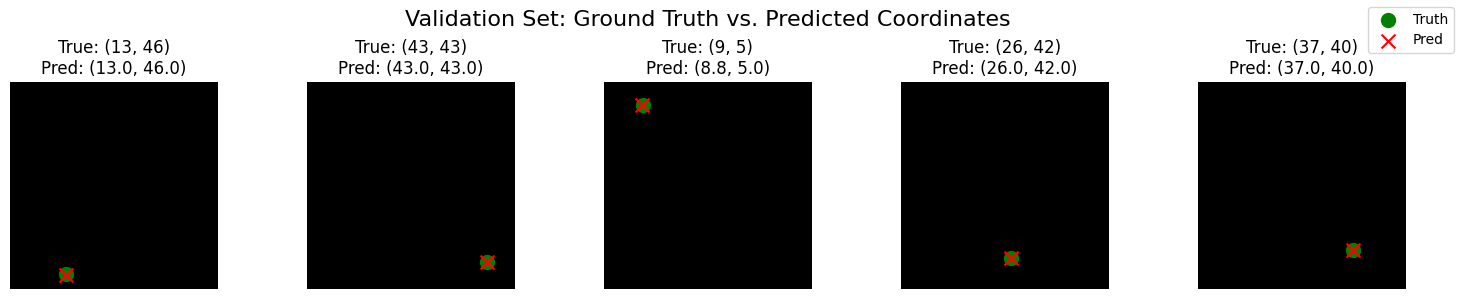

In [27]:
import torch
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval() # Set model to evaluation mode
    criterion = torch.nn.MSELoss()

    val_loss = 0.0
    correct_predictions = 0
    total_samples = len(val_loader.dataset)

    # We will save the first batch for visualization
    viz_images, viz_targets, viz_preds = None, None, None

    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            images, targets = images.to(device), targets.to(device)
            predictions = model(images)

            # Accumulate MSE loss
            loss = criterion(predictions, targets)
            val_loss += loss.item() * images.size(0)

            # Calculate Exact Pixel Accuracy (rounding the float to nearest int)
            pred_rounded = torch.round(predictions)

            # Check if both X and Y match perfectly
            matches = (pred_rounded == targets).all(dim=1)
            correct_predictions += matches.sum().item()

            # Grab the first batch for visualization
            if i == 0:
                viz_images = images.cpu()
                viz_targets = targets.cpu()
                viz_preds = predictions.cpu()

    # Final Metrics
    val_loss /= total_samples
    accuracy = (correct_predictions / total_samples) * 100

    print("-" * 30)
    print(f"Validation Loss (MSE): {val_loss:.4f}")
    print(f"Exact Pixel Match Accuracy: {accuracy:.2f}%")
    print("-" * 30)

    # ---------------------------------------------------------
    # Visualization
    # ---------------------------------------------------------
    num_visualize = 5
    fig, axes = plt.subplots(1, num_visualize, figsize=(15, 3))

    for i in range(num_visualize):
        img = viz_images[i].squeeze().numpy()
        true_x, true_y = viz_targets[i].numpy()
        pred_x, pred_y = viz_preds[i].numpy()

        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        # Plot True (Green O)
        axes[i].scatter(true_x, true_y, color='green', marker='o', s=100, label='Truth' if i==0 else "")
        # Plot Predicted (Red X)
        axes[i].scatter(pred_x, pred_y, color='red', marker='x', s=100, label='Pred' if i==0 else "")

        axes[i].set_title(f"True: ({int(true_x)}, {int(true_y)})\nPred: ({pred_x:.1f}, {pred_y:.1f})")
        axes[i].axis('off')

    fig.legend(loc='upper right')
    plt.suptitle("Validation Set: Ground Truth vs. Predicted Coordinates", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run the evaluation!
evaluate_and_visualize(model, val_loader)

In [29]:
# Define the file path
model_save_path = 'two_neuron_model_weights.pth'

# Save only the state_dict (the learned weights)
torch.save(model.state_dict(), model_save_path)

print(f"Model weights successfully saved to: {model_save_path}")

Model weights successfully saved to: two_neuron_model_weights.pth


In [32]:
import torch
import os

def quantize_and_save_model(model, save_path='quantized_two_neuron_model.pth'):
    print("Starting Post-Training Dynamic Quantization...")

    # 1. Quantization in PyTorch is currently best supported on CPU
    model.cpu()
    model.eval()

    # 2. Apply Dynamic Quantization
    # We explicitly tell PyTorch to target nn.Linear layers and use 8-bit integers
    quantized_model = torch.quantization.quantize_dynamic(
        model,
        {torch.nn.Linear},
        dtype=torch.qint8
    )

    # 3. Save the quantized weights
    torch.save(quantized_model.state_dict(), save_path)
    print(f"Quantized model saved to: {save_path}")

    # 4. Compare File Sizes
    # Save the original for a fair comparison
    orig_path = 'temp_orig.pth'
    torch.save(model.state_dict(), orig_path)

    orig_size = os.path.getsize(orig_path) / 1024
    quant_size = os.path.getsize(save_path) / 1024

    print("-" * 30)
    print(f"Original Size (Float32) : {orig_size:.2f} KB")
    print(f"Quantized Size (Int8)   : {quant_size:.2f} KB")
    print(f"Size Reduction          : {(1 - quant_size/orig_size)*100:.2f}%")
    print("-" * 30)

    return quantized_model

# Run the quantization
quantized_model = quantize_and_save_model(model)

Starting Post-Training Dynamic Quantization...
Quantized model saved to: quantized_two_neuron_model.pth
------------------------------
Original Size (Float32) : 21.18 KB
Quantized Size (Int8)   : 7.45 KB
Size Reduction          : 64.83%
------------------------------


/tmp/ipython-input-2182460048.py:13: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


## 5. Evaluation & Statistical Metrics
To thoroughly evaluate the model, we calculate the final MSE on the validation set.

Furthermore, to bridge the gap between continuous regression outputs and discrete integer pixel coordinates, we round the model's predictions. This allows us to calculate an **Exact Pixel Match Accuracy** percentage. We also visualize a sample batch to confirm the predicted coordinates (Red X) perfectly align with the ground truth (Green O).

Evaluating Quantized Model on CPU...
----------------------------------------
Quantized Validation Loss : 32.7803
Quantized Pixel Accuracy  : 95.15%
Average CPU Inference     : 0.7645 ms/image
----------------------------------------
[X-Coordinate Metrics]
Precision : 0.9855 | Recall : 0.9568 | F1-Score : 0.9674

[Y-Coordinate Metrics]
Precision : 0.9858 | Recall : 0.9544 | F1-Score : 0.9658
----------------------------------------


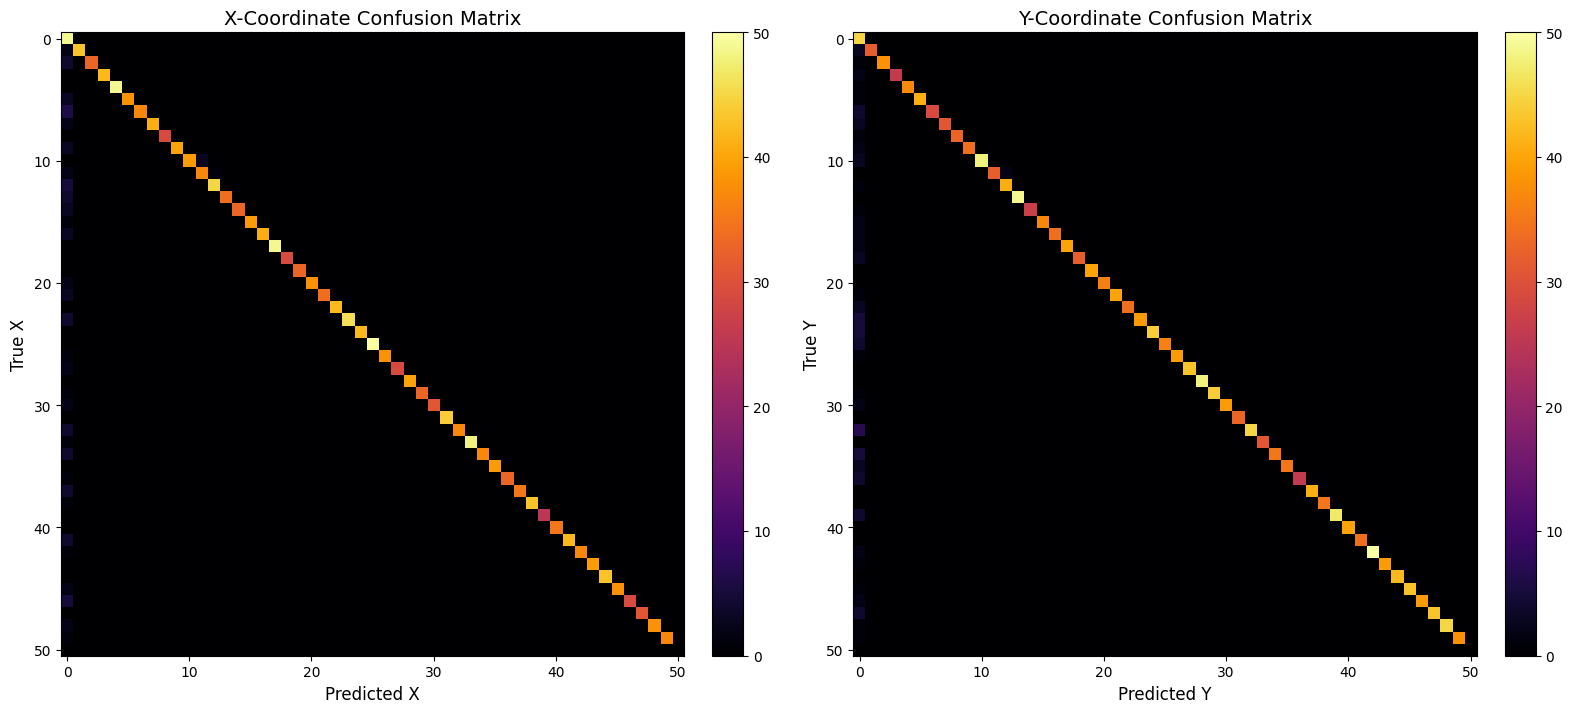

In [38]:
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_quantized_model_comprehensive(q_model, val_loader):
    print("Evaluating Quantized Model on CPU...")

    # Force execution on CPU
    device = torch.device("cpu")
    q_model.to(device)
    q_model.eval()

    criterion = torch.nn.MSELoss()

    val_loss = 0.0
    correct_predictions = 0
    total_samples = len(val_loader.dataset)

    # Lists to hold coordinates for sklearn metrics
    true_x_list, true_y_list = [], []
    pred_x_list, pred_y_list = [], []

    # Track inference time
    start_time = time.perf_counter()

    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)

            predictions = q_model(images)

            # Accumulate regression loss
            loss = criterion(predictions, targets)
            val_loss += loss.item() * images.size(0)

            # Round predictions to nearest integer for classification metrics
            pred_rounded = torch.round(predictions)
            matches = (pred_rounded == targets).all(dim=1)
            correct_predictions += matches.sum().item()

            # Populate lists for precision/recall/F1
            for j in range(targets.size(0)):
                true_x_list.append(int(targets[j, 0].item()))
                true_y_list.append(int(targets[j, 1].item()))

                p_x = int(pred_rounded[j, 0].item())
                p_y = int(pred_rounded[j, 1].item())

                # Clamp out-of-bounds predictions to '50' (Error Bin)
                if p_x < 0 or p_x > 49: p_x = 50
                if p_y < 0 or p_y > 49: p_y = 50

                pred_x_list.append(p_x)
                pred_y_list.append(p_y)

    end_time = time.perf_counter()

    # --- Metric Calculations ---
    val_loss /= total_samples
    accuracy = (correct_predictions / total_samples) * 100
    latency_ms = ((end_time - start_time) / total_samples) * 1000

    t_x = np.array(true_x_list)
    t_y = np.array(true_y_list)
    p_x = np.array(pred_x_list)
    p_y = np.array(pred_y_list)

    # Macro-averaged metrics (treats every coordinate 0-49 as an equally important class)
    f1_x = f1_score(t_x, p_x, average='macro', zero_division=0)
    rec_x = recall_score(t_x, p_x, average='macro', zero_division=0)
    prec_x = precision_score(t_x, p_x, average='macro', zero_division=0)

    f1_y = f1_score(t_y, p_y, average='macro', zero_division=0)
    rec_y = recall_score(t_y, p_y, average='macro', zero_division=0)
    prec_y = precision_score(t_y, p_y, average='macro', zero_division=0)

    # --- Print Text Output ---
    print("-" * 40)
    print(f"Quantized Validation Loss : {val_loss:.4f}")
    print(f"Quantized Pixel Accuracy  : {accuracy:.2f}%")
    print(f"Average CPU Inference     : {latency_ms:.4f} ms/image")
    print("-" * 40)

    print("[X-Coordinate Metrics]")
    print(f"Precision : {prec_x:.4f} | Recall : {rec_x:.4f} | F1-Score : {f1_x:.4f}")

    print("\n[Y-Coordinate Metrics]")
    print(f"Precision : {prec_y:.4f} | Recall : {rec_y:.4f} | F1-Score : {f1_y:.4f}")
    print("-" * 40)

    # --- Visual Confusion Matrices ---
    # labels=[0..50] ensures a fixed 51x51 matrix where index 50 catches out-of-bounds errors
    labels = list(range(51))
    cm_x = confusion_matrix(t_x, p_x, labels=labels)
    cm_y = confusion_matrix(t_y, p_y, labels=labels)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # X Confusion Matrix
    im_x = axes[0].imshow(cm_x, interpolation='nearest', cmap='inferno')
    axes[0].set_title("X-Coordinate Confusion Matrix", fontsize=14)
    axes[0].set_xlabel("Predicted X", fontsize=12)
    axes[0].set_ylabel("True X", fontsize=12)
    fig.colorbar(im_x, ax=axes[0], fraction=0.046, pad=0.04)

    # Y Confusion Matrix
    im_y = axes[1].imshow(cm_y, interpolation='nearest', cmap='inferno')
    axes[1].set_title("Y-Coordinate Confusion Matrix", fontsize=14)
    axes[1].set_xlabel("Predicted Y", fontsize=12)
    axes[1].set_ylabel("True Y", fontsize=12)
    fig.colorbar(im_y, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run the comprehensive evaluation
evaluate_quantized_model_comprehensive(quantized_model, val_loader)

In [34]:
# To load it back later:
base_model = TwoNeuronRegressor(img_size=50).cpu().eval()

# Prep the architecture to accept int8 weights
prepared_model = torch.quantization.quantize_dynamic(
    base_model, {torch.nn.Linear}, dtype=torch.qint8
)

# Load the quantized weights
prepared_model.load_state_dict(torch.load('quantized_two_neuron_model.pth'))

/tmp/ipython-input-3645789792.py:5: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared_model = torch.quantization.quantize_dynamic(
/usr/local/lib/python3.12/dist-packages/torch/_utils.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using sto

<All keys matched successfully>

## 6. Hardware-Aware "Row-Processor" Architecture (FPGA/Edge Optimized)
Standard matrix multiplications require buffering the entire $50 \times 50$ image into memory before processing. In a severely resource-constrained environment (like an FPGA streaming pixels from a camera sensor via SCCB/I2C), full-frame buffering is expensive in terms of Block RAM.

To eliminate the need for a frame buffer, we introduce a **Streaming Row-Processor** architecture:
* **The Network:** Instead of a $2500 \to 2$ dense layer, we deploy exactly 50 parallel neurons (`nn.Linear(50, 50, bias=False)`).
* **Hardware Mapping:** The network processes exactly one row (50 pixels) per clock cycle.
    * The **$Y$-coordinate** is determined purely by the hardware row-counter (the loop index).
    * The **$X$-coordinate** is determined by whichever of the 50 neurons fires a high activation.
* **Early Exit Inference:** The moment a row triggers a neuron above a specific threshold, the inference engine halts, returns the $(X, Y)$ coordinates, and flushes the remaining image data to save power and clock cycles.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim

class FPGARowProcessor(nn.Module):
    def __init__(self, row_width=50):
        super(FPGARowProcessor, self).__init__()
        # 50 Parallel Neurons.
        # Input: 50 pixels (1 row). Output: 50 neuron activations.
        self.neurons = nn.Linear(row_width, row_width, bias=False)

    def forward(self, x):
        # x shape: (Batch, 50)
        return self.neurons(x)

    def early_exit_inference(self, image, threshold=0.5):
        """
        Simulates the FPGA row-by-row scanning hardware logic.
        """
        # Ensure image is 2D: shape (50, 50)
        image = image.squeeze()

        # The 'y' loop acts as the row counter in your FPGA
        for y in range(image.shape[0]):
            row = image[y]

            # Pass the single row to the 50 parallel neurons
            # Unsqueeze to simulate a batch dimension of 1
            outputs = self(row.unsqueeze(0)).squeeze()

            # Hardware comparator logic: check if any neuron fires above threshold
            max_val, max_idx = torch.max(outputs, dim=0)

            if max_val > threshold:
                # The X coordinate is the index of the neuron that fired
                x = max_idx.item()
                return torch.tensor([float(x), float(y)])

        # Fallback if no bright pixel is found
        return torch.tensor([-1.0, -1.0])

## 7. Hardware-Aware Training Strategy
Training a sequential row-by-row loop in a framework like PyTorch destroys GPU acceleration. To train this FPGA-style architecture efficiently, we must mathematically simulate the row-wise processing using parallelized batch tensors.

**The Row-Flattening Technique:**
1. We take a batch of $50 \times 50$ images and flatten the spatial dimensions so that each image becomes 50 independent 1D rows. A batch of 64 images becomes a tensor of $3200$ independent rows.
2. We construct a target matrix of the exact same shape.
3. For the 3136 "dark" rows, the target is an array of pure `0`s.
4. For the 64 "active" rows (the specific $Y$-index where the bright pixel lives), we set the $X$-th index of the target array to `1.0`.
5. We train the 50 parallel neurons using Mean Squared Error (MSE) to output `0.0` for dark pixels and `1.0` for the active pixel.

In [36]:
def train_fpga_model(train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")

    model = FPGARowProcessor(row_width=50).to(device)

    # We use MSE Loss to teach the neurons to output exactly 0.0 or 1.0
    criterion = nn.MSELoss()

    # Standard learning rate is fine here because targets are normalized (0.0 or 1.0)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 10

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, targets in train_loader:
            batch_size = images.size(0)
            # Remove channel dim -> Shape: (Batch, 50, 50)
            images = images.to(device).squeeze()
            targets = targets.to(device) # Shape: (Batch, 2) [x, y]

            # --- PREPARE DATA FOR ROW-WISE TRAINING ---
            # Flatten the images so each row is treated as an independent sample
            # Shape becomes (Batch * 50, 50)
            rows = images.view(-1, 50)

            # Create target vectors for each row.
            # Shape: (Batch * 50, 50). Initialized entirely to 0.
            row_targets = torch.zeros((batch_size * 50, 50), device=device)

            # Set the specific neuron to 1.0 ONLY for the row that has the bright pixel
            for b in range(batch_size):
                true_x = int(targets[b, 0].item())
                true_y = int(targets[b, 1].item())

                # Calculate the absolute index of the active row in the flattened batch
                active_row_idx = (b * 50) + true_y

                # Set the target neuron for that specific row to 1.0
                row_targets[active_row_idx, true_x] = 1.0

            # --- FORWARD PASS & BACKPROP ---
            optimizer.zero_grad()
            predictions = model(rows)

            loss = criterion(predictions, row_targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_size

        train_loss /= len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.6f}")

    return model

# Run the training
fpga_model = train_fpga_model(train_loader, val_loader)

Training on: cpu
Epoch [1/10] | Train Loss: 0.000173
Epoch [2/10] | Train Loss: 0.000009
Epoch [3/10] | Train Loss: 0.000000
Epoch [4/10] | Train Loss: 0.000000
Epoch [5/10] | Train Loss: 0.000000
Epoch [6/10] | Train Loss: 0.000000
Epoch [7/10] | Train Loss: 0.000000
Epoch [8/10] | Train Loss: 0.000000
Epoch [9/10] | Train Loss: 0.000000
Epoch [10/10] | Train Loss: 0.000000


## 8. Comprehensive Evaluation & Statistical Metrics
Because this architecture effectively turns the regression problem into two simultaneous 50-class classification problems (one for $X$ and one for $Y$), we can evaluate it using rigorous statistical metrics typically reserved for classification.

Using `scikit-learn`, we calculate the **Macro-Averaged Precision, Recall, and F1-Score** for both the $X$-coordinate neurons and the $Y$-coordinate row counter.

We also generate $50 \times 50$ **Confusion Matrices**. A perfectly trained model will produce a solid black heatmap with a single, perfectly straight, bright diagonal line from $(0,0)$ to $(49,49)$, indicating zero coordinate drift. If the early-exit threshold fails or triggers on sensor noise, the error is bucketed into a synthetic "Class 50" to clearly visualize the failure rate.

--- Stage 1: Running Early-Exit Inference ---
Processed batch 10/32...
Processed batch 20/32...
Processed batch 30/32...

--- Stage 2: Calculating Statistical Metrics ---
Total Samples Analyzed : 2000
Exact Pixel Match      : 100.00%

[X-Coordinate Metrics]
Precision : 1.0000 | Recall : 1.0000 | F1-Score : 1.0000

[Y-Coordinate Metrics (Early Exit Counter)]
Precision : 1.0000 | Recall : 1.0000 | F1-Score : 1.0000

--- Stage 3: Generating Confusion Matrices ---


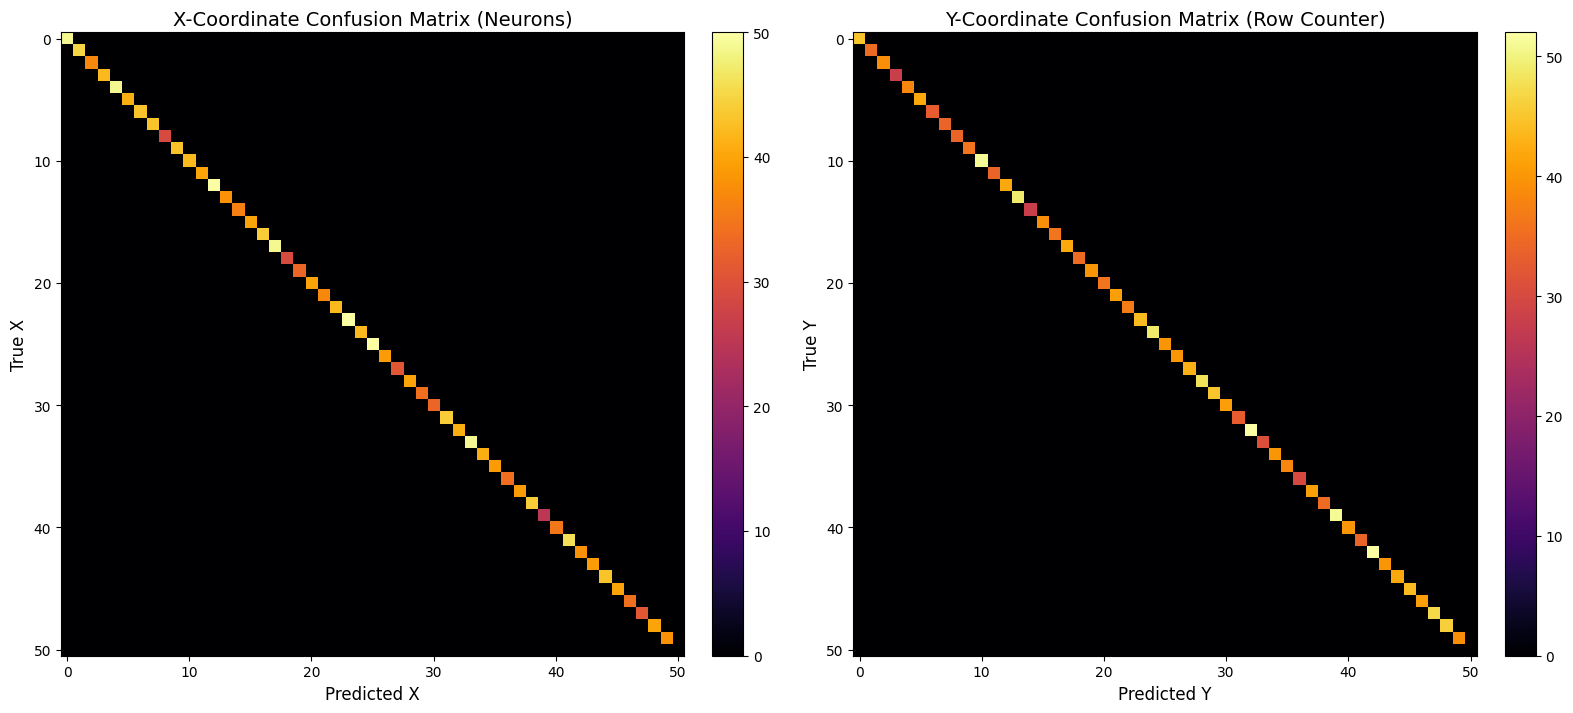

In [37]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_fpga_early_exit(model, val_loader):
    print("--- Stage 1: Running Early-Exit Inference ---")
    model.cpu()
    model.eval()

    true_x_list = []
    true_y_list = []
    pred_x_list = []
    pred_y_list = []

    # We don't need gradients for evaluation
    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            # Process one image at a time to simulate the hardware
            for j in range(images.size(0)):
                img = images[j]
                target_x = int(targets[j, 0].item())
                target_y = int(targets[j, 1].item())

                # Run the custom early-exit inference
                pred_coords = model.early_exit_inference(img, threshold=0.5)
                p_x = int(pred_coords[0].item())
                p_y = int(pred_coords[1].item())

                # If the model failed to find a pixel (-1), assign it to class 50
                # so it shows up as an error in our 50x50 metrics
                if p_x == -1: p_x = 50
                if p_y == -1: p_y = 50

                true_x_list.append(target_x)
                true_y_list.append(target_y)
                pred_x_list.append(p_x)
                pred_y_list.append(p_y)

            if (i + 1) % 10 == 0:
                print(f"Processed batch {i + 1}/{len(val_loader)}...")

    print("\n--- Stage 2: Calculating Statistical Metrics ---")
    # Convert lists to numpy arrays
    t_x = np.array(true_x_list)
    t_y = np.array(true_y_list)
    p_x = np.array(pred_x_list)
    p_y = np.array(pred_y_list)

    # Calculate Exact Pixel Match (Accuracy)
    exact_matches = np.sum((t_x == p_x) & (t_y == p_y))
    total_samples = len(t_x)
    accuracy = (exact_matches / total_samples) * 100

    # Calculate Macro-Averaged Precision, Recall, and F1
    # 'macro' calculates metrics for each coordinate (0-49) and finds their unweighted mean.
    # zero_division=0 prevents warnings if a specific coordinate is never predicted.
    f1_x = f1_score(t_x, p_x, average='macro', zero_division=0)
    rec_x = recall_score(t_x, p_x, average='macro', zero_division=0)
    prec_x = precision_score(t_x, p_x, average='macro', zero_division=0)

    f1_y = f1_score(t_y, p_y, average='macro', zero_division=0)
    rec_y = recall_score(t_y, p_y, average='macro', zero_division=0)
    prec_y = precision_score(t_y, p_y, average='macro', zero_division=0)

    print(f"Total Samples Analyzed : {total_samples}")
    print(f"Exact Pixel Match      : {accuracy:.2f}%\n")

    print("[X-Coordinate Metrics]")
    print(f"Precision : {prec_x:.4f} | Recall : {rec_x:.4f} | F1-Score : {f1_x:.4f}")

    print("\n[Y-Coordinate Metrics (Early Exit Counter)]")
    print(f"Precision : {prec_y:.4f} | Recall : {rec_y:.4f} | F1-Score : {f1_y:.4f}")

    print("\n--- Stage 3: Generating Confusion Matrices ---")
    # Generate the 50x50 matrices
    # labels=[i for i in range(51)] ensures the matrix is fixed at 51x51 (0-49 valid, 50 is error)
    labels = list(range(51))
    cm_x = confusion_matrix(t_x, p_x, labels=labels)
    cm_y = confusion_matrix(t_y, p_y, labels=labels)

    # Plotting as images
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # X Confusion Matrix
    im_x = axes[0].imshow(cm_x, interpolation='nearest', cmap='inferno')
    axes[0].set_title("X-Coordinate Confusion Matrix (Neurons)", fontsize=14)
    axes[0].set_xlabel("Predicted X", fontsize=12)
    axes[0].set_ylabel("True X", fontsize=12)
    fig.colorbar(im_x, ax=axes[0], fraction=0.046, pad=0.04)

    # Y Confusion Matrix
    im_y = axes[1].imshow(cm_y, interpolation='nearest', cmap='inferno')
    axes[1].set_title("Y-Coordinate Confusion Matrix (Row Counter)", fontsize=14)
    axes[1].set_xlabel("Predicted Y", fontsize=12)
    axes[1].set_ylabel("True Y", fontsize=12)
    fig.colorbar(im_y, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run the evaluator
evaluate_fpga_early_exit(fpga_model, val_loader)

In [39]:
import torch

# Define the file name
fpga_model_save_path = 'fpga_row_processor_weights.pth'

# Save ONLY the weights (state_dict), which is the PyTorch best practice
torch.save(fpga_model.state_dict(), fpga_model_save_path)

print(f"FPGA Model weights successfully saved to: {fpga_model_save_path}")

# Trigger the download in Google Colab
try:
    from google.colab import files
    files.download(fpga_model_save_path)
    print("Download initiated!")
except ImportError:
    print("Not running in Google Colab. File saved to local directory.")

FPGA Model weights successfully saved to: fpga_row_processor_weights.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated!


In [40]:
# --- How to load the model for inference ---

# 1. Initialize a fresh instance of your custom FPGA architecture
loaded_fpga_model = FPGARowProcessor(row_width=50)

# 2. Load the weights into the architecture
# Using map_location='cpu' ensures it works on any machine
loaded_fpga_model.load_state_dict(torch.load(fpga_model_save_path, map_location=torch.device('cpu')))

# 3. Always set to evaluation mode before running inference!
loaded_fpga_model.eval()

print("FPGA Model successfully loaded and ready for early-exit inference!")

FPGA Model successfully loaded and ready for early-exit inference!
